In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

In [2]:
%%HTML
<style> code {background-color : orange !important;} </style>
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Load our image
binary_warped = mpimg.imread('test_images/warped_example.jpg')

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    #print("nonzeroxy", nonzero)
    #print("nonzerox", nonzerox)
    #print("nonzeroy", nonzeroy)
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        #print("======================= processing window: ", window)
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current -  margin# Update this
        win_xleft_high = leftx_current +  margin # Update this
        win_xright_low = rightx_current -  margin  # Update this
        win_xright_high = rightx_current +  margin  # Update this
        
        # Draw the windows on the visualization image
        lineWidth = 3
        color = (0,255,0)
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), color, lineWidth) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), color, lineWidth) 
        
        leftWindow = binary_warped[win_y_low : win_y_high, win_xleft_low : win_xleft_high]
        rightWindow = binary_warped[win_y_low : win_y_high, win_xright_low : win_xright_high]
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###      
        good_left_inds = np.transpose(np.nonzero(leftWindow))
        good_right_inds = np.transpose(np.nonzero(rightWindow))
        #good_left_inds = np.nonzero(leftWindow)
        #good_right_inds = np.nonzero(rightWindow)
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        nonzeroLeft = leftWindow.nonzero()
        nonzeroxLeft = nonzeroLeft[1]
        
        nonzeroRight = rightWindow.nonzero()
        nonzeroxRight = nonzeroRight[1]
        
        if (len(nonzeroxLeft) > minpix):
            leftGoodPixelAvgX = int(np.mean(nonzeroxLeft))
        else:
            leftGoodPixelAvgX = margin
            
        if (len(nonzeroxRight) > minpix):
            rightGoodPixelAvgX = int(np.mean(nonzeroxRight))
        else:
            rightGoodPixelAvgX = margin
                    
        #print("leftGoodPixelAvgX= ", leftGoodPixelAvgX)
        #print("rightGoodPixelAvgX= ", rightGoodPixelAvgX)
              
        left_peak = leftGoodPixelAvgX + win_xleft_low
        right_peak = rightGoodPixelAvgX + win_xright_low
        #print("peaksLR= ({}, {})".format(left_peak, right_peak))

        colorLine = (255, 130, 0)
        Pt0 = (int(left_peak), win_y_low)
        Pt1 = (int(left_peak), win_y_high)
        cv2.line(out_img, Pt0, Pt1, colorLine, lineWidth)
        
        Pt0 = (int(right_peak), win_y_low)
        Pt1 = (int(right_peak), win_y_high)
        cv2.line(out_img, Pt0, Pt1, colorLine, lineWidth)
 
        leftx_current = left_peak
        rightx_current = right_peak

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

#%matplotlib qt4
#%matplotlib inline
#%matplotlib notebook
#leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
#plt.figure(figsize=(12,8))
#plt.imshow(out_img)
#plt.tight_layout()


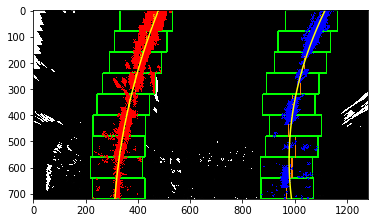

In [4]:

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(binary_warped)
#%matplotlib qt4
#%matplotlib notebook
#%matplotlib inline

plt.imshow(out_img)